# Selected features

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('SBAnational.csv')
df.head(1)

/var/folders/41/hgg8f6_j1dj4y4mt0w22d8ym0000gn/T/ipykernel_21831/2675700227.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('SBAnational.csv')


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"


In [3]:
# I'm gonna drop a bumch of columns that I don't care about for now. I will leave the feature "name" for traceability.
drop_columns = ['LoanNr_ChkDgt', 'City', 'State', 'Zip', 'BankState', 'ApprovalDate', 'ApprovalFY',
                'CreateJob', 'RetainedJob', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
                'BalanceGross', 'ChgOffPrinGr']
df.drop(drop_columns, inplace=True, axis=1)
df.head(1)

,Name,Bank,NAICS,Term,NoEmp,NewExist,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
0,ABC HOBBYCRAFT,FIFTH THIRD BANK,451120,84,4,2.0,1,0,N,Y,P I F,"$60,000.00","$48,000.00"


In [4]:
# Drop data with null MIS_Status, as it is useless
df.dropna(subset=['MIS_Status'], inplace=True)
df['MIS_Status'].describe()

count     897167
unique         2
top        P I F
freq      739609
Name: MIS_Status, dtype: object

In [5]:
# Encode the target variable to binary values
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['PaidInFull'] = label_encoder.fit_transform(df['MIS_Status'])
df.drop(['MIS_Status'], inplace=True, axis=1)
print(df['PaidInFull'].describe())
# Paid in Full is encoded as 1

count    897167.000000
mean          0.824383
std           0.380494
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: PaidInFull, dtype: float64


## Direct Inclusion

Can be directly included or with minimum manipulation.

### Bank
Bank Name\
**Encoding:**\
One-Hot for tree-based models. An idea is to create a few columns like Bank A, Bank B, Bank C with the major banks.\
<mark>TODO: Identify most common banks.</mark> \
For regression models we could encode each bank with the percentage of default of its previous loans.\
**Cleaning:**\
1559 nulls.\
One-Hot should be able to fix nulls, as a null bank would just be 0 in each column.

In [6]:
df['Bank'].describe()


count                         895661
unique                          5801
top       BANK OF AMERICA NATL ASSOC
freq                           86773
Name: Bank, dtype: object

In [7]:
top_5_banks = df['Bank'].value_counts().head(5)
print(f"\nThe top 5 most common banks:")
top_5_banks


The top 5 most common banks:


Bank
BANK OF AMERICA NATL ASSOC        86773
WELLS FARGO BANK NATL ASSOC       63461
JPMORGAN CHASE BANK NATL ASSOC    48131
U.S. BANK NATIONAL ASSOCIATION    35112
CITIZENS BANK NATL ASSOC          33770
Name: count, dtype: int64

In [8]:
print(f"{len(df[df['Bank'].isnull()])} nulls")

1506 nulls


### NAICS
North American Industry Classification System code\
**Encoding:**\
It does not make sense as a float number. Needs to be changed to a string.\
One-Hot for tree-based models. We can do a similar encoding as in the *Bank* feature. See [census](https://www.census.gov/naics/?58967?yearbck=2012) for identifying the industries. Note: It's the 1997 naming for some reason, not the 2012 one. Probably they are even mixed.
<mark>TODO: Identify most common industries.</mark> \
For regression-based models we could do the same as for *bank* and just substitute it for its default ratio.\
**Cleaning:**\
A bunch of them have 0 value.
<mark>TODO: Decide what to do with the zeros.</mark> \

In [9]:
# Change to a string to get categorical descriptions.
df['NAICS'] = df['NAICS'].astype(str)
df['NAICS'].describe()

count     897167
unique      1312
top            0
freq      201667
Name: NAICS, dtype: object

In [10]:
top_naics = df['NAICS'].value_counts().head()
print(f"\nThe top 5 most common NAICS:")
top_naics


The top 5 most common NAICS:


NAICS
0         201667
722110     27941
722211     19435
811111     14539
621210     14034
Name: count, dtype: int64

### Term
Loan term in months\
**Encoding:**\
For regression models it is inmediate, being a numeric feature.\
For tree-based models we may have to build bins. An idea would be to divide it into short, medium and long terms.
<mark>TODO: Design bins to divide the terms.</mark>

In [11]:
df['Term'].describe()

count    897167.000000
mean        110.848592
std          78.900862
min           0.000000
25%          60.000000
50%          84.000000
75%         120.000000
max         569.000000
Name: Term, dtype: float64

In [12]:
# Helper function to draw histograms
def draw_histogram(column: pd.DataFrame, name: str, nbins: int = 50, log=False):
    plt.figure(figsize=(8, 6))
    plt.hist(column, bins=nbins, alpha=0.7, color='skyblue', edgecolor='black', log=log)
    plt.title(f'Histogram of {name}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

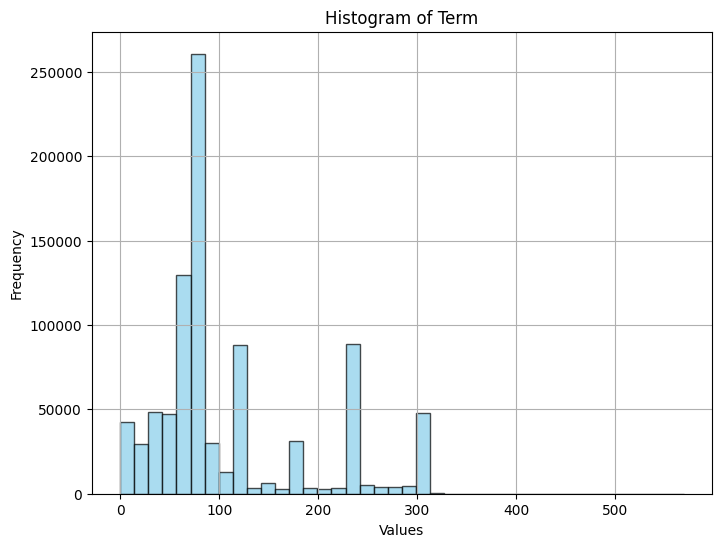

In [13]:
draw_histogram(df['Term'], 'Term', 40)

### NoEmp
Number of Business Employees\
**Encoding:**\
For linear models it makes sense to use directly as a feature.\
For tree based models we might want to make bins for different business sizes.
<mark>TODO: Design bins to divide the business sizes.</mark>

In [14]:
df['NoEmp'].describe()

count    897167.000000
mean         11.412562
std          73.793775
min           0.000000
25%           2.000000
50%           4.000000
75%          10.000000
max        9999.000000
Name: NoEmp, dtype: float64

In [15]:
# These are some of the biggest ones. They could maybe be considered as outliers.
df[df['NoEmp'] >= 9800]

,Name,Bank,NAICS,Term,NoEmp,NewExist,FranchiseCode,UrbanRural,RevLineCr,LowDoc,GrAppv,SBA_Appv,PaidInFull
7816,"OAKS PHARMACY, INC.",CITIZENS BANK OF PENNSYLVANIA,446110,36,9992,2.0,1,0,N,Y,"$55,000.00","$44,000.00",1
44584,R & R SALES,ALERUS FINANCIAL NATL ASSOC,0,84,9999,2.0,0,0,N,N,"$50,000.00","$45,000.00",0
164076,BRADLEY I. & LINDA M. AULIN,FIVE STAR BANK,0,63,9999,1.0,1,0,N,N,"$200,000.00","$150,000.00",0
505737,"TOTEM PRESS, INC.",U.S. BANK NATIONAL ASSOCIATION,0,120,9999,1.0,1,0,N,N,"$143,000.00","$114,400.00",1
613940,GRAPHIC COMMUNICATION A HAWAII,FIRST HAWAIIAN BANK,541430,84,9999,1.0,1,0,N,N,"$21,000.00","$18,900.00",1
873293,WILL'S FAMILY FAVORITES,CALIFORNIA BANK & TRUST,0,70,9945,1.0,1,0,0,N,"$145,000.00","$108,750.00",1


In [16]:
# What should we do with the fellas with 0 employees?
print(f"{len(df[df['NoEmp'] < 1])} have 0 employees")

6621 have 0 employees


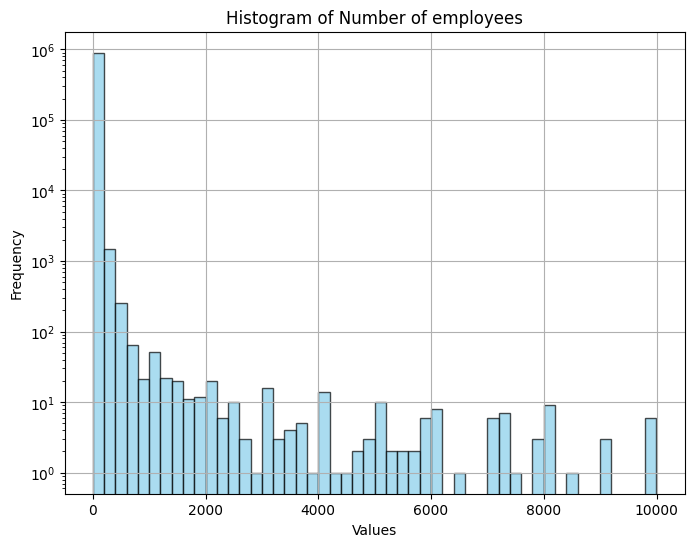

In [17]:
# I'll only pull the ones under 50 to see with bigger detail.
#draw_histogram(df[df['NoEmp']<=50]['NoEmp'], "Number of employees", 50)
draw_histogram(df['NoEmp'], "Number of employees", 50, log=True)

### NewExist
1 = Existing Business, 2 = New Business\
**Encoding:**\
For both trees and regressions, the encoding is straightforward binary, 1 = existing, 0 = new.\
**Cleaning:**\
1028 values with 0.0.\
We can fill them with the mode (Existing) or toss the samples.
<mark>TODO: Decide what to do with the nulls.</mark>

In [18]:
df['NewExist'] = df['NewExist'].astype(str)
df['NewExist'].describe()

count     897167
unique         4
top          1.0
freq      643446
Name: NewExist, dtype: object

In [19]:
# 136 nulls.
df['NewExist'].value_counts()

NewExist
1.0    643446
2.0    252559
0.0      1028
nan       134
Name: count, dtype: int64

### FranchiseCode
Franchise Code 00000 or 00001 = No Franchise\
**Encoding:**\
Has to be changed to strings.
For both tree and regression models it would be good to feature engineer it into a division between *no-franchise, major-franchise and other-franchise*. We could have one bin for Subway, Quiznos, etc; one for other franchises and one for no franchise.\
Some values included are:\
78760: Subway\
68020: Quiznos\
50564: Mail Boxes Etc\
21780: Dairy Queen\
25650: Dunkin\
79140: Super 8\
<mark>TODO: Design bins to divide the franchises.</mark>

In [20]:
df['FranchiseCode'] = df['FranchiseCode'].astype(str)
df['FranchiseCode'].describe()

count     897167
unique      2767
top            1
freq      637395
Name: FranchiseCode, dtype: object

In [21]:
top_franchises = df['FranchiseCode'].value_counts().head(10)
print(f"\nThe top 10 most common franchises:")
top_franchises


The top 10 most common franchises:


FranchiseCode
1        637395
0        208040
78760      3373
68020      1921
50564      1034
21780      1001
25650       715
79140       659
22470       615
17998       606
Name: count, dtype: int64

### UrbanRural
1= Urban, 2= Rural, 0 = Undefined\
**Encoding:**\
Changed to string. It has to be one-hot encoding for both trees and regression. 105343 are undefined, so it should be its own cathegory.

In [22]:
df['UrbanRural'] = df['UrbanRural'].astype(str)
df['UrbanRural'].describe()

count     897167
unique         3
top            1
freq      469281
Name: UrbanRural, dtype: object

In [23]:
df['UrbanRural'].value_counts()

UrbanRural
1    469281
0    322826
2    105060
Name: count, dtype: int64

### RevLineCr
Revolving Line of Credit: Y = Yes\
**Encoding:**\
Makes sense to binary-encode it for both trees and regression. \
**Cleaning:**\
There is a significative amount of possible values which don't have a clear meaning (i.e. 0, T, 1, R, 2, C). There are also nulls.
<mark>TODO: Clean this data. </mark>

In [24]:
df['RevLineCr'].describe()

count     892647
unique        18
top            N
freq      419252
Name: RevLineCr, dtype: object

In [25]:
df['RevLineCr'].value_counts()

RevLineCr
N    419252
0    257431
Y    200660
T     15239
1        23
R        14
`        11
2         6
C         2
3         1
,         1
7         1
A         1
5         1
.         1
4         1
-         1
Q         1
Name: count, dtype: int64

In [26]:
print(f"{len(df[df['RevLineCr'].isnull()])} nulls")

4520 nulls


### LowDoc
LowDoc Loan Program: Y = Yes, N = No\
**Encoding:**\
Makes sense to binary-encode it for both trees and regression. \
**Cleaning:**\
There is a significative amount of possible values which don't have a clear meaning (i.e. 0, C, S, A, 1). There are also nulls.
<mark>TODO: Clean this data. </mark>

In [27]:
df['LowDoc'].describe()

count     894589
unique         8
top            N
freq      780997
Name: LowDoc, dtype: object

In [28]:
df['LowDoc'].value_counts()

LowDoc
N    780997
Y    110171
0      1490
C       758
S       603
A       495
R        74
1         1
Name: count, dtype: int64

In [29]:
print(f"{len(df[df['LowDoc'].isnull()])} nulls")

2578 nulls


In [30]:
#Convert dollar values to float value
def dollar_to_float(dollar_string: str):
    return float(dollar_string.replace('$','').replace(',',''))

### GRAppv
Gross Amount of Loan Approved by Bank\
**Encoding:**\
Has to be translated into floats.

In [31]:
df['GrAppv'] = df['GrAppv'].apply(dollar_to_float)

# Scientific notation is useless for now
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df['GrAppv'].describe()


count    897167.000
mean     193059.517
std      283433.114
min        1000.000
25%       35000.000
50%       90000.000
75%      225000.000
max     5472000.000
Name: GrAppv, dtype: float64

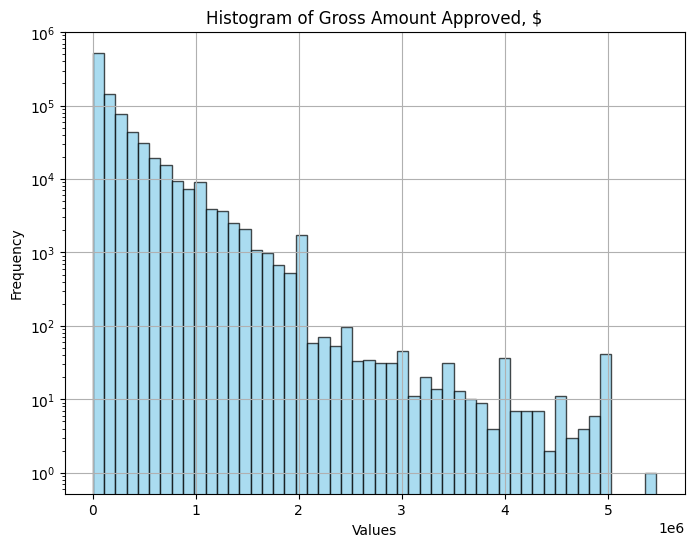

In [32]:
# I will go over the loans under $1 million.

#draw_histogram(df[df['GrAppv'] < 1000000]['GrAppv'], 'Gross Amount Approved, $', 50)
draw_histogram(df['GrAppv'], 'Gross Amount Approved, $', 50, log=True)

### SBA_Appv
SBA’s Guaranteed Amount of Approved Loan\
**Encoding:**\
Has to be translated into floats.

In [33]:
df['SBA_Appv'] = df['SBA_Appv'].apply(dollar_to_float)
df['SBA_Appv'].describe()

count    897167.000
mean     149780.699
std      228559.980
min         500.000
25%       21250.000
50%       62050.000
75%      175000.000
max     5472000.000
Name: SBA_Appv, dtype: float64

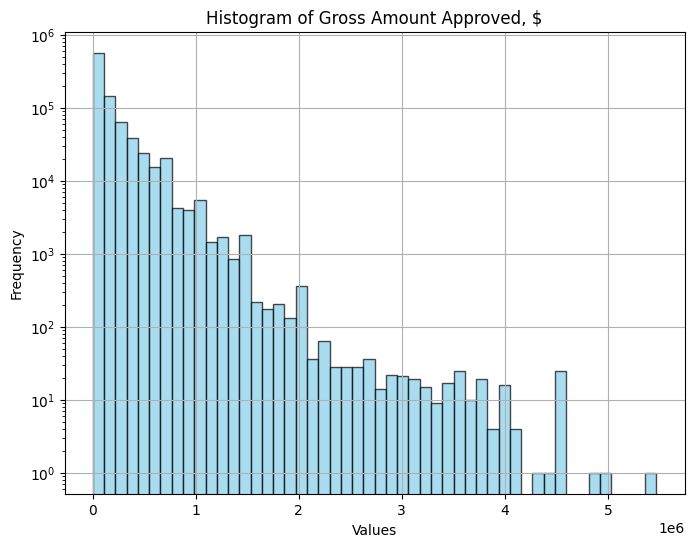

In [34]:
# I will go over the loans under $200k.

#draw_histogram(df[df['SBA_Appv'] < 200000]['SBA_Appv'], 'Gross Amount Approved, $', 50)
draw_histogram(df['SBA_Appv'], 'Gross Amount Approved, $', 50, log=True)

## Engineered Features

### SBARatio
The percentage of loan insured by SBA

In [35]:
df['SBARatio'] = df['SBA_Appv'] / df['GrAppv']
df['SBARatio'].describe()

count   897167.000
mean         0.710
std          0.174
min          0.028
25%          0.500
50%          0.750
75%          0.850
max          1.000
Name: SBARatio, dtype: float64

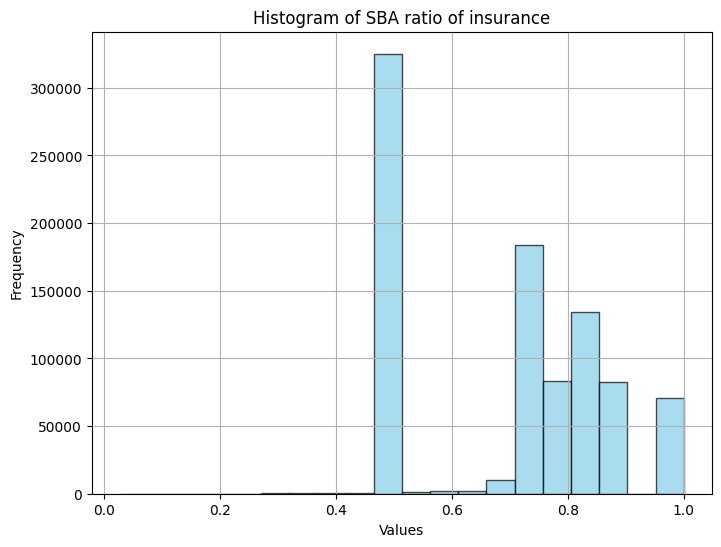

In [36]:
draw_histogram(df['SBARatio'], 'SBA ratio of insurance', 20)
# Most are located in round numbers, like 50%, 75%, 80% etc.

### NAICS_i
NAICS as an integer to perform correlation analysis

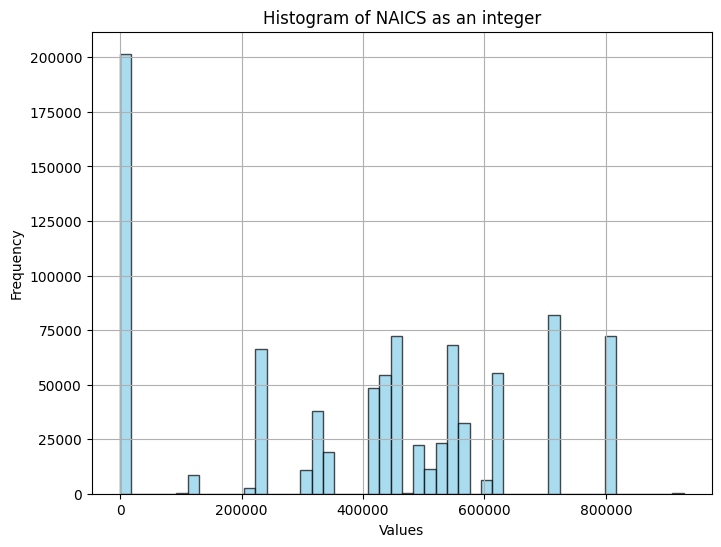

In [37]:
df['NAICS_i'] = df['NAICS'].astype(int)
draw_histogram(df['NAICS_i'], "NAICS as an integer", 50)

### FranchiseCode_i
FranchiseCode as an integer to perform correlation analysis

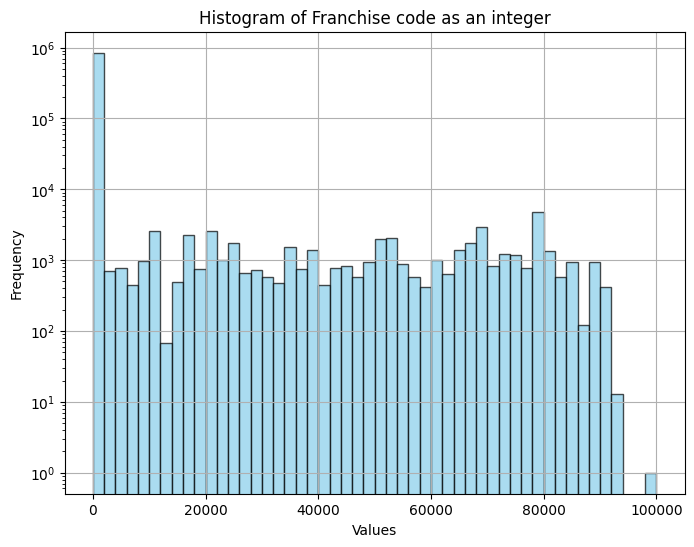

In [38]:
df['FranchiseCode_i'] = df['FranchiseCode'].astype(int)
draw_histogram(df['FranchiseCode_i'], "Franchise code as an integer", 50, True)

### isFranchise
Binary version of FranchiseCode

In [39]:
# Function to create the 'isFranchise' column
def is_franchise(code):
    return 0 if code in [0, 1] else 1

df['isFranchise'] = df['FranchiseCode_i'].apply(is_franchise)

In [40]:
df['isFranchise'].describe()

count   897167.000
mean         0.058
std          0.233
min          0.000
25%          0.000
50%          0.000
75%          0.000
max          1.000
Name: isFranchise, dtype: float64

## Correlation study

In [41]:
df.columns

Index(['Name', 'Bank', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'FranchiseCode',
       'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBA_Appv', 'PaidInFull',
       'SBARatio', 'NAICS_i', 'FranchiseCode_i', 'isFranchise'],
      dtype='object')

In [42]:
target = 'PaidInFull'
features = [feature for feature in df.columns if feature not in target]
num_features = ['Term', 'NoEmp', 'GrAppv', 'SBA_Appv', 'SBARatio', 'NAICS_i', 'FranchiseCode_i', 'isFranchise']
cat_features = [feature for feature in features if feature not in num_features]

print(f"Cathegorical features: {cat_features}")
print(f"Numeric features: {num_features}")

Cathegorical features: ['Name', 'Bank', 'NAICS', 'NewExist', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc']
Numeric features: ['Term', 'NoEmp', 'GrAppv', 'SBA_Appv', 'SBARatio', 'NAICS_i', 'FranchiseCode_i', 'isFranchise']


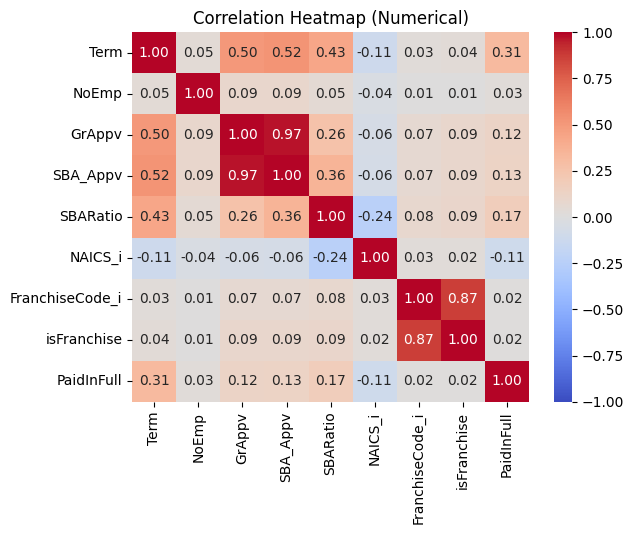

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
numeric_corr = df[num_features + [target]].corr()

# Generate heatmap
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Numerical)')
plt.show()
# The correlation between the number of employees and the target seems to be minimal.

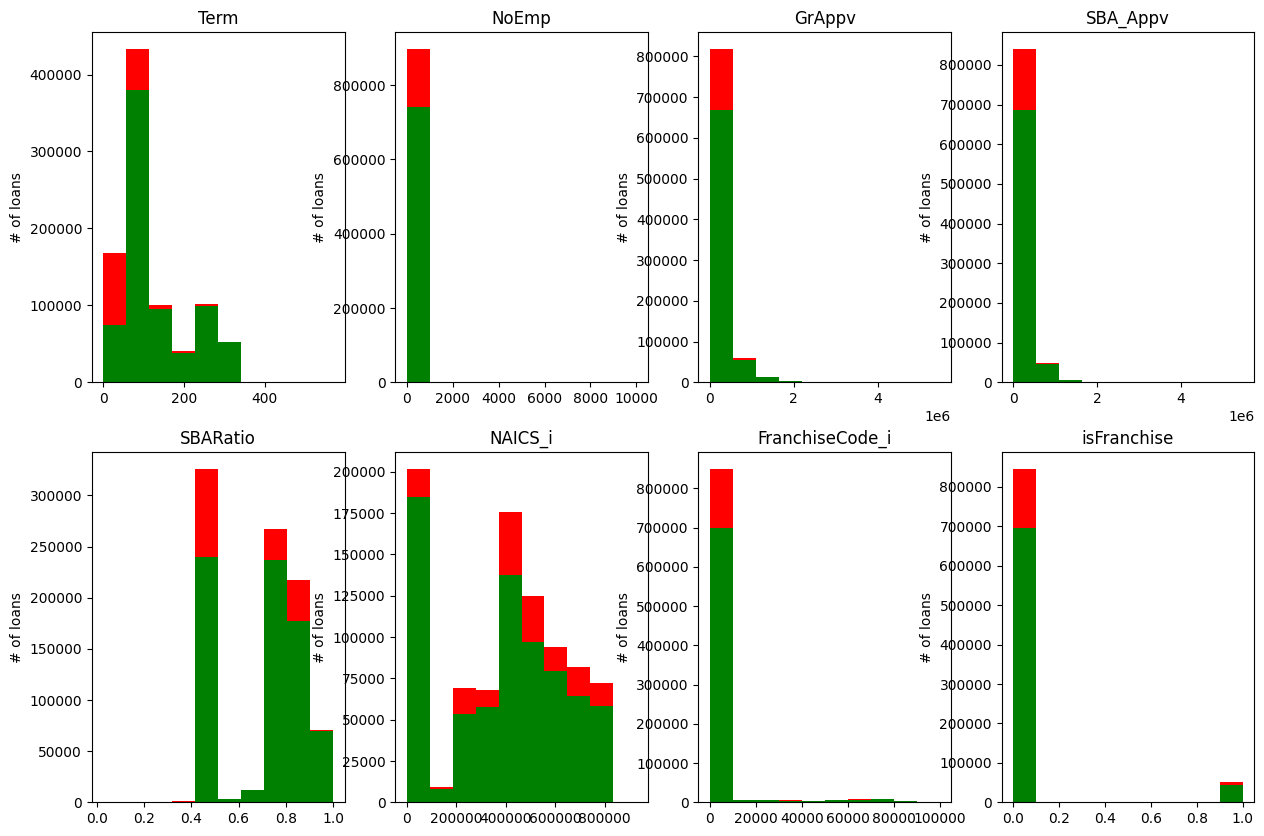

In [44]:
import matplotlib.pyplot as plt
i = 241
plt.figure(figsize=(15, 10))
for num_feature in num_features:
    plt.subplot(i)
    plt.hist(x = [df[df[target]==1][num_feature], df[df[target]==0][num_feature]], 
            stacked=True, color = ['g','r'])
    plt.title(num_feature)
    plt.ylabel('# of loans')
    i += 1


# plt.subplot(235)
# plt.hist(x = [df[df[target]==1]['NoEmp'], df[df[target]==0]['NoEmp']], 
#          stacked=True, color = ['g','r'])
# plt.title('NoEmp')
# plt.xlabel('NoEmp')
# plt.ylabel('# of loans')

# plt.subplot(236)
# plt.hist(x = [df[df[target]==1]['SBARatio'], df[df[target]==0]['SBARatio']], 
#          stacked=True, color = ['g','r'])
# plt.title('SBARatio')
# plt.xlabel('SBARatio')
# plt.ylabel('# of loans')


## Crosstab analysis

In [45]:
cross_tab = pd.crosstab(df['NewExist'], df[target])
cross_tab['Ratio'] = cross_tab[1] / cross_tab.sum(axis=1)

cross_tab

PaidInFull,0,1,Ratio
NewExist,,,
0.0,63,965,0.939
1.0,110114,533332,0.829
2.0,47367,205192,0.812
nan,14,120,0.896


In [46]:
cross_tab = pd.crosstab(df['UrbanRural'], df[target])
cross_tab['Ratio'] = cross_tab[1] / cross_tab.sum(axis=1)

cross_tab

PaidInFull,0,1,Ratio
UrbanRural,,,
0,22978,299848,0.929
1,114867,354414,0.755
2,19713,85347,0.812


In [47]:
cross_tab = pd.crosstab(df['RevLineCr'], df[target])
cross_tab['Ratio'] = cross_tab[1] / cross_tab.sum(axis=1)

cross_tab

PaidInFull,0,1,Ratio
RevLineCr,,,
",",0,1,1.000
-,0,1,1.000
.,0,1,1.000
0,38492,218939,0.850
1,2,21,0.913
2,0,6,1.000
3,0,1,1.000
4,0,1,1.000
5,0,1,1.000


In [48]:
cross_tab = pd.crosstab(df['LowDoc'], df[target])
cross_tab['Ratio'] = cross_tab[1] / cross_tab.sum(axis=1)

cross_tab

PaidInFull,0,1,Ratio
LowDoc,,,
0,50,1440,0.966
1,0,1,1.000
A,159,336,0.679
C,75,683,0.901
N,146077,634920,0.813
R,25,49,0.662
S,270,333,0.552
Y,9904,100267,0.910


In [49]:
cross_tab = pd.crosstab(df['isFranchise'], df[target])
cross_tab['Ratio'] = cross_tab[1] / cross_tab.sum(axis=1)

cross_tab

PaidInFull,0,1,Ratio
isFranchise,,,
0,149698,695737,0.823
1,7860,43872,0.848


In [50]:
cross_tab = pd.crosstab(df['FranchiseCode'], df[target])
cross_tab['Ratio'] = cross_tab[1] / cross_tab.sum(axis=1)

cross_tab = cross_tab.sort_values(by=0, ascending=False)
cross_tab.head(20)

PaidInFull,0,1,Ratio
FranchiseCode,,,
1,78523,558872,0.877
0,71175,136865,0.658
68020,492,1429,0.744
17998,196,410,0.677
52000,182,394,0.684
78760,158,3215,0.953
65140,98,96,0.495
50564,93,941,0.910
10528,86,349,0.802


In [51]:
cross_tab = pd.crosstab(df['Bank'], df[target])
cross_tab['Ratio'] = cross_tab[1] / cross_tab.sum(axis=1)

cross_tab = cross_tab.sort_values(by=0, ascending=False)
cross_tab.head(20)

PaidInFull,0,1,Ratio
Bank,,,
BANK OF AMERICA NATL ASSOC,23914,62859,0.724
JPMORGAN CHASE BANK NATL ASSOC,13235,34896,0.725
BBCN BANK,12628,10350,0.450
CAPITAL ONE NATL ASSOC,9189,13058,0.587
WELLS FARGO BANK NATL ASSOC,8967,54494,0.859
CITIZENS BANK NATL ASSOC,7531,26239,0.777
U.S. BANK NATIONAL ASSOCIATION,6133,28979,0.825
"PNC BANK, NATIONAL ASSOCIATION",5342,21998,0.805
"SUPERIOR FINANCIAL GROUP, LLC",3539,1303,0.269


## Density study of numerical vars

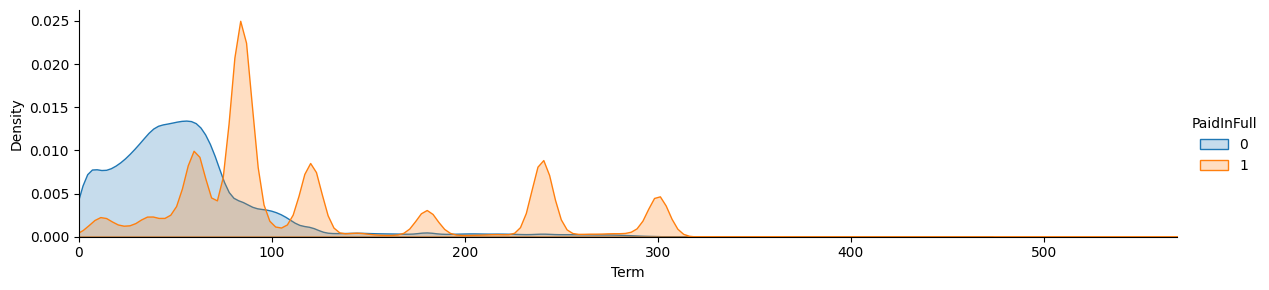

In [52]:
a = sns.FacetGrid( df, hue = target, aspect=4 )
a.map(sns.kdeplot, 'Term', fill= True )
a.set(xlim=(0 , df['Term'].max()))
a.add_legend()

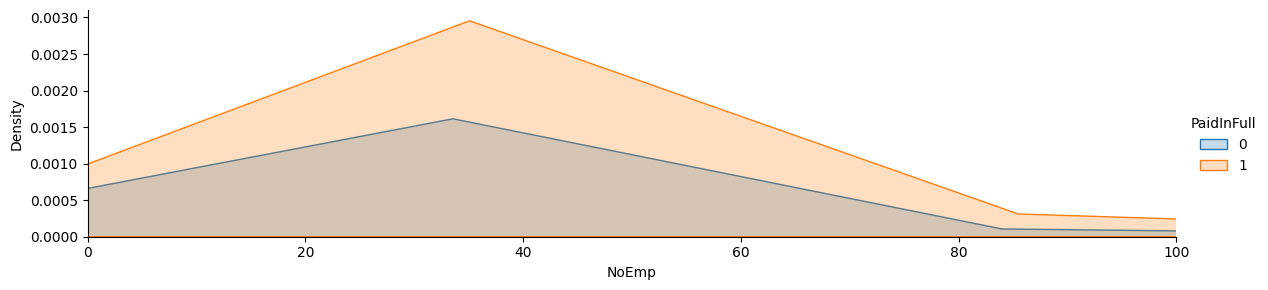

In [53]:
a = sns.FacetGrid( df, hue = target, aspect=4 )
a.map(sns.kdeplot, 'NoEmp', fill= True )
a.set(xlim=(0 , 100))
a.add_legend()

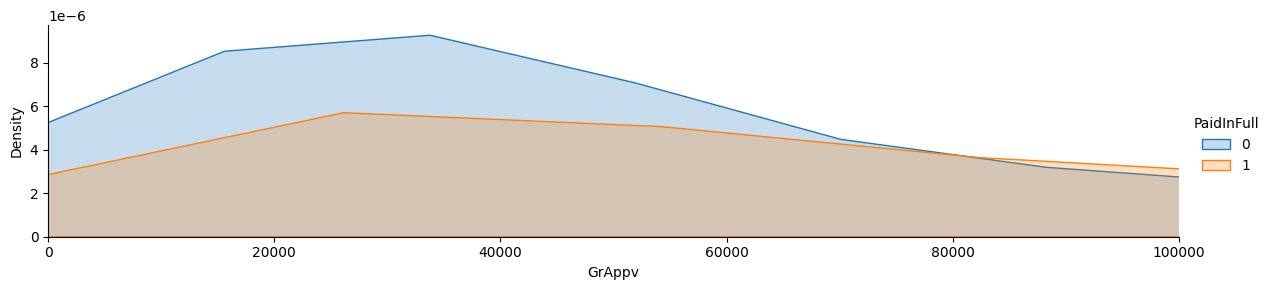

In [54]:
a = sns.FacetGrid( df, hue = target, aspect=4 )
a.map(sns.kdeplot, 'GrAppv', fill= True )
a.set(xlim=(0, 100000))
a.add_legend()

In [55]:
a = sns.FacetGrid( df, hue = target, aspect=4 )
a.map(sns.kdeplot, 'SBA_Appv', fill= True )
a.set(xlim=(0, 100000))
a.add_legend()

In [ ]:
a = sns.FacetGrid( df, hue = target, aspect=4 )
a.map(sns.kdeplot, 'SBARatio', fill= True )
a.set(xlim=(0, df['SBARatio'].max()))
a.add_legend()

In [ ]:
a = sns.FacetGrid( df, hue = target, aspect=4 )
a.map(sns.kdeplot, 'NAICS_i', fill= True )
a.set(xlim=(0, df['NAICS_i'].max()))
a.add_legend()

In [ ]:
a = sns.FacetGrid( df, hue = target, aspect=4)
a.map(sns.kdeplot, 'FranchiseCode_i', fill= True)
a.set(xlim=(0, df['FranchiseCode_i'].max()))
a.add_legend()